# RQ2. Actionable population density motif discovery

For this research question, we look for non-trivial patterns that occurred at least five times on weekends and share similarities in absolute values. To achieve this, we set the subsequence size to 12 hours ($m=12$) and conducted an exhaustive search for the top-1 nearest neighbor motifs. We rank the motifs based on the median of the top-$k$ distances using the $Score_{unified}$ metric instead of solely relying on the distance to the nearest match. This approach enables us to discover any top-$k$ motifs by computing different $Score_{unified}$ values without incurring the computational overhead of creating top-$k$ matrix profiles.


In [4]:
import math
import os

import matplotlib.dates as mdates
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL, STL

from msig import Motif, NullModel

params = {"legend.fontsize": "xx-large", "axes.labelsize": 20}
pylab.rcParams.update(params)

In [5]:
# read csv
hourly_taz_data = pd.read_csv(
    "../data/populationdensity/hourly_taz.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)
# taz_id to taz_name dict
taz_id_name = {}
for taz_id in hourly_taz_data["taz_id"].unique():
    taz_name = hourly_taz_data[hourly_taz_data["taz_id"] == taz_id]["taz_name"].values[
        0
    ]
    taz_id_name[taz_id] = taz_name

hourly_taz_data = hourly_taz_data[hourly_taz_data["taz_name"] != "Beato (Picheleira)"]
hourly_taz_data = hourly_taz_data[
    hourly_taz_data["taz_name"] != "Alcântara (Ribeirinha - Belém)"
]
hourly_taz_data

,taz_id,taz_name,one_time,sum_terminals,sum_roaming_terminals,sum_terminals_with_active_data,sum_roaming_terminals_with_active_data,sum_phonecalls,sum_ended_phonecalls,avg_upstream_bandwidth,avg_downstream_bandwidth,min_avg_downstream_bandwidth,min_avg_upstream_bandwidth,max_upstream_bandwidth,max_downstream_bandwidth,sum_sum_terminals_sharing,wkt_taz
0,69,Areeiro (Alto Pina),2021-11-26 09:00:00,61599.0,1131.0,58113.0,1107.0,2896.0,574.0,7524.772105,101178.976512,104.328000,105.621997,39330404.0,135947840.0,0.00,POLYGON ((-9.131441060130475 38.74471703960398...
1,70,Arroios (Estefânia),2021-11-26 09:00:00,145078.0,4477.0,138532.0,4351.0,5149.0,1178.0,7678.938176,53412.218959,2752.320035,14550.430893,63988960.0,405100896.0,12.43,POLYGON ((-9.144729944918017 38.73514419538672...
2,71,Arroios (Arroios | Norte),2021-11-26 09:00:00,31194.0,945.0,29608.0,920.0,1284.0,420.0,5017.655536,58454.086946,943.014966,842.953344,3146271.0,142608816.0,0.00,POLYGON ((-9.136504202275457 38.73689574768296...
3,53,Alvalade (Campo Grande),2021-11-26 09:00:00,51055.0,864.0,48474.0,849.0,1520.0,474.0,8951.088582,70079.739010,2236.359946,17768.382601,33589812.0,96555216.0,0.00,"POLYGON ((-9.15660999782037 38.7593274576093, ..."
4,40,Lumiar (Telheiras | Oeste),2021-11-26 09:00:00,40523.0,255.0,37014.0,252.0,2314.0,382.0,3442.786203,32570.243025,1.238571,0.000000,16425652.0,168218912.0,0.00,"POLYGON ((-9.17712280774748 38.76422000124379,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175218,16,Estrela (Estrela),2021-11-26 09:00:00,199615.0,6739.0,190222.0,6497.0,7990.0,1839.0,10347.174511,75677.619332,573.914546,628.886265,67788656.0,566004672.0,0.00,"POLYGON ((-9.16455004654274 38.71408737534585,..."
175219,12,Ajuda (Ajuda | Norte),2021-11-26 09:00:00,27901.0,487.0,25890.0,481.0,1100.0,342.0,199281.838168,236425.820611,0.000000,0.000000,130461056.0,152884192.0,0.00,POLYGON ((-9.194104152143993 38.72438283212201...
175220,15,Estrela (Lapa),2021-11-26 09:00:00,9932.0,432.0,9298.0,429.0,605.0,154.0,3801.634144,39603.158490,1.328000,0.000000,1539097.0,67348640.0,0.00,POLYGON ((-9.167543700000001 38.70657329999994...
175221,13,Estrela (Ribeirinha - Belém),2021-11-26 09:00:00,6586.0,138.0,6119.0,138.0,410.0,77.0,2781.907062,16101.249632,0.000000,0.000000,11564562.0,18501752.0,0.00,POLYGON ((-9.161911000000002 38.70242249999994...


In [6]:
results_path = "../results/populationdensity/rq2/hourly_taz"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")

In [7]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
resids = {}

# get the data for São Domingos de Benfica (Estrada Luz | Oeste)
taz_data = hourly_taz_data[
    hourly_taz_data["taz_name"] == "São Domingos de Benfica (Estrada Luz | Oeste)"
]
taz_data = taz_data.drop(columns=["taz_name"])
taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
taz_id = taz_data["taz_id"].values[0]
taz_data = taz_data.drop(columns=["one_time", "taz_id", "wkt_taz"])
taz_data.set_index("datetime", inplace=True)
for data_feature in features:
    time_serie = taz_data[[data_feature]].asfreq("h")
    if np.all(time_serie == 0):
        continue
    res = MSTL(np.squeeze(time_serie), periods=[24, 24 * 7]).fit()
    resids[str(taz_id) + "_" + data_feature] = res.resid

    var_resid = np.var(res.resid)
    var_observed = np.var(res.observed)
    trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
    noise_strength = var_resid / var_observed

    seasonal_individial_strengths = {}
    for period in res.seasonal:
        seasonal_individial_strengths["F_" + str(period)] = max(
            0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
        )
    seasonal_strength = max(
        0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
    )

    stats_df = {
        "id": taz_id,
        "Name": taz_id_name[taz_id],
        "Feature": data_feature,
        "F_T": round(trend_strength, 3),
        "F_S": round(seasonal_strength, 3),
        "F_R": round(noise_strength, 3),
    }

    # add individual seasonal strengths to stats_df, rounded with 3 decimals
    for period in seasonal_individial_strengths:
        stats_df[period] = round(seasonal_individial_strengths[period], 3)

    stats_table = pd.concat(
        [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
    )

pd.DataFrame(resids).to_csv(results_path + "/resids.csv", index=True)
stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
stats_table.head()

,id,Name,Feature,F_T,F_S,F_R,F_seasonal_24,F_seasonal_168
0,37,São Domingos de Benfica (Estrada Luz | Oeste),sum_terminals,0.059,0.404,0.574,0.267,0.236


In [8]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
include = None
top_k_mp = 1
normalize = False
subsequence_lengths = [12]

resids = pd.read_csv(results_path + "/resids.csv", index_col=0)

# plot the data and residuals of top taz_id
top_rq2_taz_ids = stats_table["id"].head(1).values
# create dataframe with taz_id and resids
top_resids = pd.DataFrame()
for taz_id in top_rq2_taz_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            hourly_taz_data[hourly_taz_data["taz_id"] == taz_id][
                [data_feature, "one_time"]
            ]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": taz_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": resids[str(taz_id) + "_" + data_feature],
        }
        top_resids = pd.concat([top_resids, pd.DataFrame(row)], ignore_index=True)


def make_av_weekend(data, m, weekends=True):
    av = np.zeros(len(data) - m + 1)
    for i in range(len(data) - m + 1):
        if weekends:
            # 0 if weekday, 1 if weekend
            if data.index[i].weekday() >= 5:
                av[i] = 1
        else:
            # 0 if weekend, 1 if weekday
            if data.index[i].weekday() < 5:
                av[i] = 0
    return av


for m in subsequence_lengths:
    for i, df in top_resids.groupby(by=["id", "feature"]):
        X = np.squeeze(df["residuals"].values)
        out = stumpy.stump(X, m, normalize=normalize, k=top_k_mp)
        mp = out[:, 0]
        av = np.ones(len(X) - m + 1)
        cmp = mp + ((1 - av) * np.max(mp))
        mp = cmp
        np.save(
            results_path
            + "/mp/hourly_taz_normalize={}_topkmp={}_m={}_{}_{}_correctedweekends.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            out,
            allow_pickle=True,
        )

In [9]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [10]:
k_distances = 5
min_neighbors = 5
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = None
for i, df in top_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.DataFrame()
    for m in subsequence_lengths:
        X = np.squeeze(df["residuals"].values)
        mp = np.load(
            results_path
            + "/mp/hourly_taz_normalize={}_topkmp={}_m={}_{}_{}_correctedweekends.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            allow_pickle=True,
        )
        motif_distances, motif_indices = stumpy.motifs(
            X,
            mp[:, 0],
            max_distance=max_distance,
            max_matches=max_matches,
            cutoff=cutoff,
            min_neighbors=min_neighbors,
            max_motifs=max_motifs,
            normalize=normalize,
        )
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])] * len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(
            motif_indices,
            motif_distances,
            motif_subspaces,
            X,
            k_distances,
            m,
            normalize,
            max_distance,
        )
        print("Sig ", np.sum(table["p-value"] < 0.001))
        # hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
        sig = (
            table["p-value"] < critical_value
            if critical_value != 0
            else table["p-value"] <= critical_value
        )
        table["Sig_Hochber"] = sig

        print(
            "Sig after Hochberg: {}, critical value: {}".format(
                np.sum(sig), critical_value
            )
        )
        mp_stats_table = (
            table
            if mp_stats_table.empty
            else pd.concat([mp_stats_table, table], ignore_index=True)
        )
    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        ),
        index=False,
    )

37 São Domingos de Benfica (Estrada Luz | Oeste)
m:12, #Motifs:3
Sig  3
Sig after Hochberg: 2, critical value: 2.686413858360303e-06


In [11]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

for i, df in top_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(
        columns=[
            "m",
            "#motifs",
            "avg_n_matches",
            "avg_n_features",
            "avg_probability",
            "avg_pvalue",
            "#sig_motifs(<0.01)",
            "significant",
            "#sig_hochberg",
        ]
    )
    for m in motif_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        if table.empty:
            continue
        n_motifs = table.shape[0]
        n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = (
            round(table["#Matches"].mean(), 2),
            round(table["#Matches"].std(), 3),
        )
        avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
        avg_probability = table["P"].mean(), table["P"].std()
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {
            "m": m,
            "#motifs": n_motifs,
            "#sig_motifs(<0.001)": n_sig_motifs_0001,
            "significant": (n_sig_motifs_0001 * 100) / n_motifs,
            "avg_n_matches": avg_n_matches,
            "avg_n_features": avg_n_features,
        }

        motif_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if motif_stats_table.empty
            else pd.concat(
                [motif_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

    print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

37 São Domingos de Benfica (Estrada Luz | Oeste)
\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
12 & 3 & 3 & 100.000 & (5.33, 0.577) & (1.0, 0.0) \\
\bottomrule
\end{tabular}



In [12]:
# read motifs table
for i, df in top_resids.groupby(by=["id", "feature"]):
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        ),
        index_col=0,
    )

    # for motif in mp_stats_table
    indexes_to_remove = set()
    for index, motif in mp_stats_table.iterrows():
        indexes_to_remove.update(
            [
                i
                for index in eval(motif["Indices"])
                for i in range(int(index), int(index) + int(motif["m"]))
            ]
        )

    resids = df["residuals"]
    resids.index = df["index"]
    resids = pd.DataFrame(resids).T
    datetime_indexes_to_remove = resids.T.index[sorted(indexes_to_remove)]

    residual_nomatches = resids.T.copy()
    for feature in residual_nomatches.columns:
        residual_nomatches.loc[datetime_indexes_to_remove, feature] = 0
        variance_explained = 100 * (
            1
            - (
                np.mean(np.abs(residual_nomatches[feature]))
                / np.mean(np.abs(resids.T[feature]))
            )
        )
        print(f"{feature}: {variance_explained}")

residuals: 38.15142680093483


In [13]:
# get top 5 most significant for each motif length
for i, df in top_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    # excluded p-value > 0.001
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
########## m:12 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
1 & 5 & 0.177 & 0.281 & 180810.116 & 35938.346 & 89236.259 & 2.76e-07 & 14.310 \\
2 & 5 & 0.166 & 0.261 & 146424.611 & 76573.200 & 99461.157 & 2.69e-06 & 15.750 \\
0 & 6 & 0.227 & 0.108 & 102200.410 & 20398.880 & 96752.109 & 2.00e-16 & 14.530 \\
\bottomrule
\end{tabular}





In [14]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name, save_path):
    # Set up the plot with 2 columns instead of 3
    fig, axes = plt.subplots(
        ncols=2, nrows=len(ts_list), figsize=(10, 3 * len(ts_list)), squeeze=False
    )
    
    for i in range(0, len(ts_list)):
        ts = ts_list[i]
        # plot light grey background of the residual time series
        axes[i, 1].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index : index + m]
            
            # Plot the raw motif subsequence
            axes[i, 0].plot(subsequence_match.values)
            
            # Highlight the motif in the residual time series
            axes[i, 1].plot(subsequence_match, linewidth=2)

        if m <= 12:
            axes[i, 0].set_xticks(range(0, len(subsequence_match)))
            axes[i, 0].set_xticklabels(
                [
                    "i+" + str(i) if i != 0 else "i"
                    for i in range(0, len(subsequence_match))
                ]
            )
        else:
            axes[i, 0].set_xticks([0, 6, 12, 18, 23])
            axes[i, 0].set_xticklabels(["i", "i+6", "i+12", "i+18", "i+23"])

        # Format the x axis to show the time and rotate for better readability
        axes[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        
        # Add y-labels if there are multiple features (multivariate data)
        if len(ts_list) > 1:
            axes[i, 0].set_ylabel(features[i], rotation=90, size="large")

        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)
        plt.setp(axes[i, 1].xaxis.get_majorticklabels(), rotation=45)

    # Titles for the two plots
    axes[0, 0].set_title("Raw Subsequences")
    axes[0, 1].set_title("Motif in Residual TS")
    
    plt.tight_layout()
    plt.savefig(
        save_path + "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )

    return None


########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
                                0
index                            
2021-09-15 00:00:00  -5950.012402
2021-09-15 01:00:00  -3728.669900
2021-09-15 02:00:00  -3266.725071
2021-09-15 03:00:00  -5785.979137
2021-09-15 04:00:00   -326.919334
...                           ...
2021-11-30 19:00:00  31046.822605
2021-11-30 20:00:00  41384.833861
2021-11-30 21:00:00  39959.094121
2021-11-30 22:00:00  28373.497949
2021-11-30 23:00:00  16412.005172

[1848 rows x 1 columns]
Motif length:  12
   ID  k  Features   m  #Matches                                 Indices  \
0   0  1         0  12         6  [1622, 1790, 182, 949, 781, 1118, 468]   
1   1  1         0  12         5        [1294, 861, 450, 356, 139, 1461]   
2   2  1         0  12         5        [439, 1448, 849, 346, 129, 1284]   

   max(dists)  min(dists)  med(dists)     CE  Score Unified  Explained Var(%)  \
0  102200.410   20398.880   96752.109  0.227         

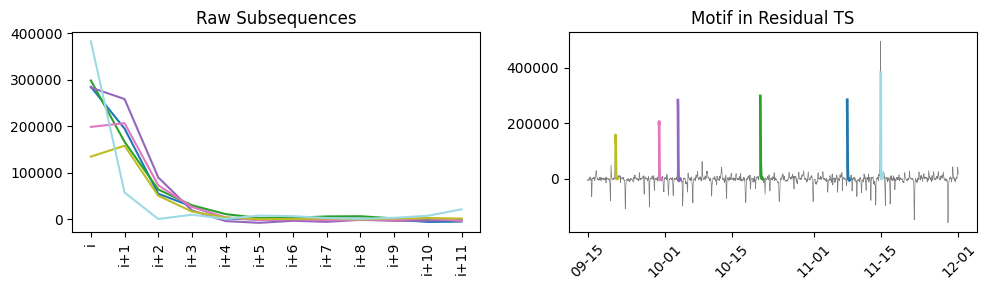

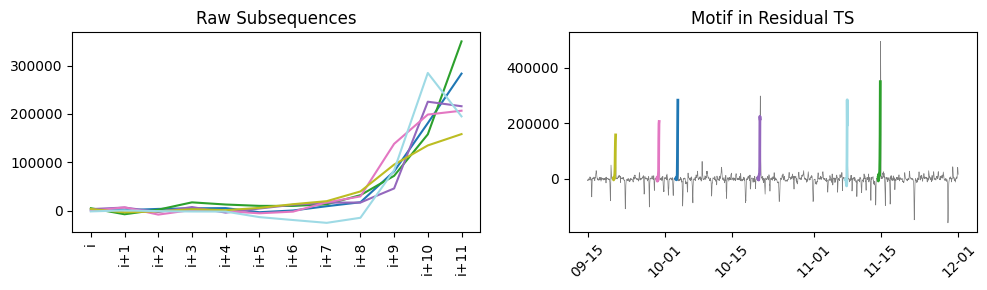

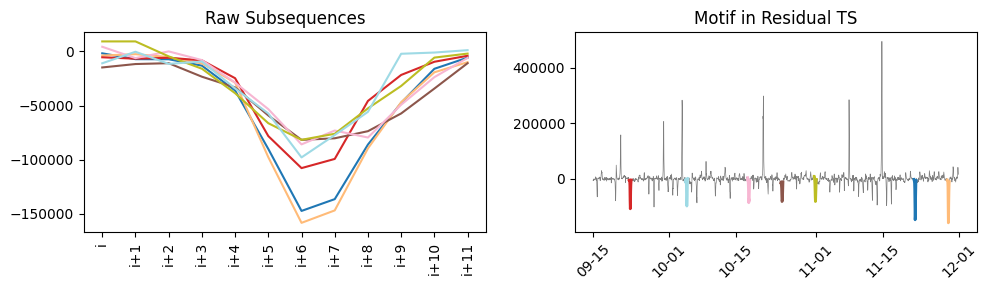

In [15]:
# plot top motif
for i, df in top_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    save_path = results_path + "/" + taz_id_name[i[0]]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(df["residuals"].values, index=pd.to_datetime(df["index"]))
    print(ts)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        print(top_motifs)
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        for top_motif in top_motifs.to_dict(orient="records"):
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif["Indices"].replace("[", "").replace("]", "").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0]) + "_" + str(i[1]) + "_" + str(top_motif["ID"])
            plot_motif([ts], features, m, indices, motif_name, save_path)